**Actions We Want To Detect**

In [ ]:
actions = ['book', 'drink', 'hello', 'idea']

Import Stuff

In [ ]:
import os
import json
import cv2
import numpy as np
from pathlib import Path

from tqdm.notebook import tqdm

# Create Dataset

**WLASL (World Level American Sign Language) Video**

WLASL is the largest video dataset for Word-Level ASL recognition, which features 2,000 common different words in ASL.

Options:

1. Get From Kaggle

2. Download From URLs

In [ ]:
option = 1  # or 2

**Option 1: Get From Kaggle**

Gets all data (about 5GB)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")

!cp -r {path} /content/

**Option 2: Download From URLs**

Customizable

In [ ]:
!pip install yt-dlp
!apt update && apt install -y ffmpeg

In [ ]:
import yt_dlp
import requests
from pathlib import Path
from urllib.parse import urlparse

Video **Download**

In [ ]:
!rm -rf videos

In [ ]:
def download_video(url, save_dir='downloads'):
    Path(save_dir).mkdir(exist_ok=True)

    parsed_url = urlparse(url)
    ext = os.path.splitext(parsed_url.path)[-1]
    filename = parsed_url.path.split("/")[-1]

    if not filename or not ext:
        print(f"Skipping unknown format: {url}")
        return None

    save_path = os.path.join(save_dir, filename)

    # Skip existing files
    if os.path.exists(save_path):
        print(f"Already exists: {save_path}")
        return save_path

    try:
        if "youtube.com" in url or "youtu.be" in url:
            import yt_dlp
            ydl_opts = {
                'outtmpl': os.path.join(save_dir, '%(id)s.%(ext)s'),
                'quiet': True,
                'format': 'bestvideo+bestaudio/best',
                'merge_output_format': 'mp4',
            }
            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                ydl.download([url])
            print(f"YouTube downloaded: {url}")
            return save_dir  # may return folder if unknown file
        elif ext in ['.mp4', '.mov']:
            r = requests.get(url, stream=True, timeout=10)
            if r.status_code == 200:
                with open(save_path, 'wb') as f:
                    for chunk in r.iter_content(1024 * 1024):
                        if chunk:
                            f.write(chunk)
                print(f"Downloaded: {save_path}")
                return save_path
            else:
                print(f"HTTP {r.status_code}: {url}")
                return None
        elif ext == '.swf':
            print(f"Skipping unsupported .swf: {url}")
            return None
        else:
            print(f"Unknown or unsupported format: {url}")
            return None
    except Exception as e:
        print(f"Failed: {url} | Error: {str(e)}")
        return None


Test

In [ ]:
video_urls = [
    # Idea
    "https://elementalaslconcepts.weebly.com/uploads/2/4/4/5/24454483/idea.mov",
    "https://media.spreadthesign.com/video/mp4/13/244655.mp4",
    "https://signstock.blob.core.windows.net/signschool/videos/db_uploads/SignSchool%20Idea%2C%20Imagine-3YjmVax6CBc.mp4",
    "https://signstock.blob.core.windows.net/signschool/videos/db_uploads/SignSchool%20Idea-HR8afgGna7A.mp4",
    "https://media.asldeafined.com/vocabulary/1468665115.4947.mp4",

    # Hello
    "https://signstock.blob.core.windows.net/signschool/videos/db_uploads/SignSchool%20Hello-6kvCOzxP9_A.mp4",
    "https://media.asldeafined.com/vocabulary/1468580623.2588.mp4",
    "https://www.handspeak.com/word/h/hello.mp4",
    "https://www.signingsavvy.com/signs/mp4/6/6353.mp4",
]

for url in video_urls:
    download_video(url)


**Get keypoints with Mediapipe**

**MediaPipe Setup**

In [ ]:
!pip install mediapipe

In [ ]:
import mediapipe as mp

In [ ]:
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

In [ ]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33, 4))
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]) if results.face_landmarks else np.zeros((468, 3))
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21, 3))
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21, 3))
    return np.concatenate([pose.flatten(), face.flatten(), lh.flatten(), rh.flatten()])


**Process and Save Keypoints**

In [ ]:
def process_video(video_path, start_frame=1, end_frame=None, bbox=None, fps=25):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Cannot open video: {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    end_frame = end_frame if end_frame and end_frame > 0 else total_frames

    keypoints = []

    for frame_num in range(start_frame, end_frame):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if not ret:
            break

        # Apply bounding box crop if provided
        if bbox:
            x1, y1, x2, y2 = bbox
            frame = frame[y1:y2, x1:x2]

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)
        keypoints.append(extract_keypoints(results))

    cap.release()
    return np.array(keypoints)

**Main Loop: Load JSON & Save Keypoints**

In [ ]:
with open("5/WLASL_Sample.json") as f:
    data = json.load(f)

for gloss_entry in tqdm(data):
    gloss = gloss_entry["gloss"]

    # Skip glosses not in the action list
    if gloss not in actions:
        continue

    print(gloss)
    for inst in gloss_entry["instances"]:
        url = inst["url"]
        bbox = inst.get("bbox", None)
        start = inst.get("frame_start", 1)
        end = inst.get("frame_end", -1)
        fps = inst.get("fps", 25)
        video_id = inst["video_id"]

        if option == 1:
            path = '5/videos'
            video_path = os.path.join(path, f'{video_id}.mp4')
        elif option == 2:
            video_path = download_video(url)
            if video_path is None:
                continue

        keypoints = process_video(video_path, start_frame=start, end_frame=end, bbox=bbox, fps=fps)
        if len(keypoints) == 0:
            continue

        save_dir = f"keypoints/{gloss}"
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        np.save(f"{save_dir}/{video_id}.npy", keypoints)


Sample

In [ ]:
np.load('keypoints/drink/17720.npy')

Download&Upload Data

In [ ]:
!zip -r /content/file.zip /content/keypoints/

In [ ]:
!unzip /content/file.zip

# Preprocess Data and Create Labels and Features

Options:

- Keras
- PyTorch (Match with the model)

Keras

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Set desired number of frames (sequence length)
MAX_FRAMES = 25

In [ ]:
data_dir = 'keypoints'
X = []  # features
y = []  # labels
label_map = {}  # class name -> index

for i, label in enumerate(os.listdir(data_dir)):
    label_path = os.path.join(data_dir, label)
    if not os.path.isdir(label_path):
        continue
    label_map[label] = i  # "book" -> 0, "drink" -> 1, etc.

    for file in os.listdir(label_path):
        if file.endswith('.npy'):
            keypoints = np.load(os.path.join(label_path, file))
            if len(keypoints.shape) != 2:  # (frames, features)
                continue  # skip corrupted or empty files
            X.append(keypoints)
            y.append(i)


# Pad all sequences to shape (MAX_FRAMES, num_features)
X = pad_sequences(X, maxlen=MAX_FRAMES, dtype='float32', padding='post', truncating='post')
y = np.array(y)

print("X shape:", X.shape)  # should be (num_samples, MAX_FRAMES, features)
print("y shape:", y.shape)


In [ ]:
# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# ensure they're NumPy arrays (if still in list form)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


In [ ]:
y_test

PyTorch

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split

In [ ]:
MAX_FRAMES = 25

class KeypointDataset(Dataset):
    def __init__(self, data_dir, max_frames=MAX_FRAMES):
        self.data = []
        self.labels = []
        self.label_map = {}
        self.max_frames = max_frames

        label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

        for idx, label in enumerate(label_dirs):
            self.label_map[label] = idx
            label_path = os.path.join(data_dir, label)

            for file in os.listdir(label_path):
                if not file.endswith('.npy'):
                    continue
                keypoints = np.load(os.path.join(label_path, file))
                if keypoints.ndim != 2:
                    continue  # skip malformed

                keypoints = torch.tensor(keypoints, dtype=torch.float32)

                # Truncate or pad to MAX_FRAMES
                if keypoints.size(0) > max_frames:
                    keypoints = keypoints[:max_frames]
                elif keypoints.size(0) < max_frames:
                    pad_len = max_frames - keypoints.size(0)
                    padding = torch.zeros(pad_len, keypoints.size(1))
                    keypoints = torch.cat([keypoints, padding], dim=0)

                self.data.append(keypoints)
                self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]      # shape: [max_frames, features]
        y = self.labels[idx]    # int label
        return x, y


In [ ]:
data_dir = 'keypoints'
full_dataset = KeypointDataset(data_dir)

# Optional: print label map
print("Label map:", full_dataset.label_map)
num_classes = len(full_dataset.label_map)

# Split: 80% train, 20% test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Explain Model



italicized text# RNN vs LSTM vs GRU

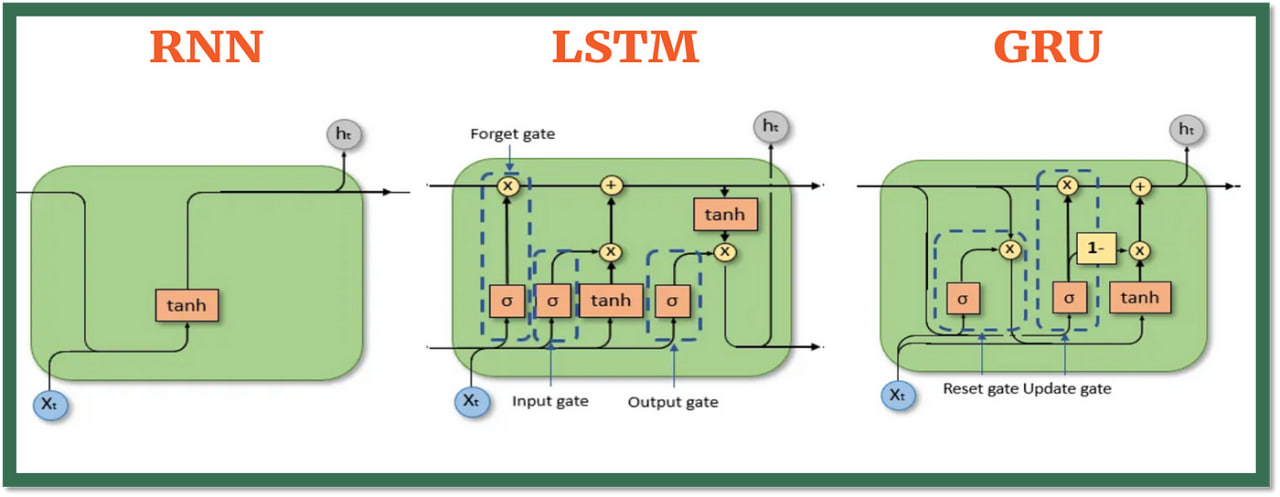

---

## RNN (Recurrent Neural Network)
RNN is designed to handle sequential data like time series, text, or video frames. It processes one element at a time, maintaining a "memory" of previous steps through a hidden state.

The update rule is:

$$
h_t = \tanh(W_h h_{t-1} + W_x x_t + b)
$$

Where:
- $h_t$: hidden state at time $t$
- $x_t$: input at time $t$
- $W_h, W_x$: weight matrices
- $b$: bias


### ⚠️ Vanishing and Exploding Gradients

Backpropagation through time involves multiplying gradients many times. This leads to:

- **Vanishing gradients**: If weights < 1 (e.g., 0.5), then:
  $$
  0.5^t \to 0 \text{ as } t \to \infty
  $$
  → network forgets long-term dependencies.

- **Exploding gradients**: If weights > 1 (e.g., 2), then:
  $$
  2^t \to \infty
  $$
  → training becomes unstable.

---

## LSTM: Long Short-Term Memory

LSTM is an improved RNN that solves the vanishing gradient problem using separate paths for long-term memories and short-term memories through a **cell state** and **three gates**.

### Gates:

- **Forget gate**: Determines what Percentage of Long-Term Memory will be remembered.

Percentage of Long-Term Memory:
  $$
  f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
  $$

- **Input gate**: Determines how we should update the Long-Term Memory.

Percentage of Potential Long-Term Memory:
  $$
  i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
  $$
Potential Long-Term Memory:
  $$
  \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
  $$

- **Cell state update**:

New Long-Term Memory:
  $$
  C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
  $$

- **Output gate**: New Short-Term Memory

Percentage of Potential Short-Term Memory::
  $$
  o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
  $$
  $\tanh(C_t)$ is Potential Short-Term Memory:
  $$
  h_t = o_t \cdot \tanh(C_t)
  $$

### Ilustration of Sample Data:

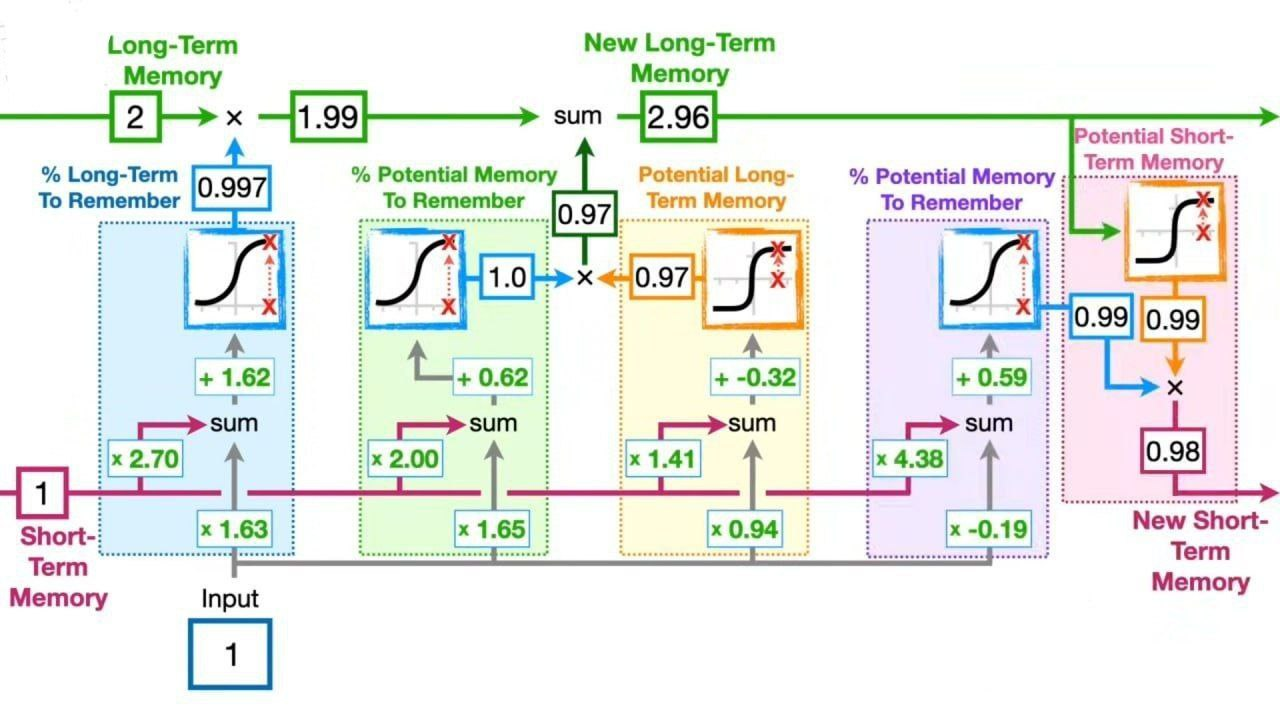

---

## GRU: Gated Recurrent Unit

GRU is a simplified version of LSTM with fewer gates.

- **Update gate** \( z_t \):
  $$
  z_t = \sigma(W_z \cdot [h_{t-1}, x_t])
  $$

- **Reset gate** \( r_t \):
  $$
  r_t = \sigma(W_r \cdot [h_{t-1}, x_t])
  $$

- **Candidate activation**:
  $$
  \tilde{h}_t = \tanh(W \cdot [r_t * h_{t-1}, x_t])
  $$

- **Final activation**:
  $$
  h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
  $$

---

## Which one to use?

Use **GRU** for faster training and smaller models.  
Use **LSTM** for complex tasks with long-term dependencies.

# **LSTM From Scratch**

In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 15.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

Parameter Naming:

| Name | Description                   |
| -------------- | ----------------------------- |
| `W_fh`         | Forget gate hidden weights    |
| `W_fx`         | Forget gate input weights     |
| `b_f`          | Forget gate bias              |
| `W_ih`         | Input gate hidden weights     |
| `W_ix`         | Input gate input weights      |
| `b_i`          | Input gate bias               |
| `W_gh`         | Candidate gate hidden weights |
| `W_gx`         | Candidate gate input weights  |
| `b_g`          | Candidate gate bias           |
| `W_oh`         | Output gate hidden weights    |
| `W_ox`         | Output gate input weights     |
| `b_o`          | Output gate bias              |


In [ ]:
class MyLSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, return_sequences=True):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.return_sequences = return_sequences

    def init_param(*shape):
        return nn.Parameter(torch.randn(*shape) * 0.1)

    mean = torch.tensor(0.0)
    std = torch.tensor(1.0)

    # Forget gate
    self.W_fh = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_dim, hidden_dim)), requires_grad=True)
    self.W_fx = nn.Parameter(torch.normal(mean=mean, std=std, size=(input_dim, hidden_dim)), requires_grad=True)
    self.b_f  = nn.Parameter(torch.tensor(0.), requires_grad=True)

    # Input gate
    self.W_ih = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_dim, hidden_dim)), requires_grad=True)
    self.W_ix = nn.Parameter(torch.normal(mean=mean, std=std, size=(input_dim, hidden_dim)), requires_grad=True)
    self.b_i  = nn.Parameter(torch.zeros(hidden_dim), requires_grad=True)

    # Candidate memory
    self.W_gh = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_dim, hidden_dim)), requires_grad=True)
    self.W_gx = nn.Parameter(torch.normal(mean=mean, std=std, size=(input_dim, hidden_dim)), requires_grad=True)
    self.b_g  = nn.Parameter(torch.zeros(hidden_dim), requires_grad=True)

    # Output gate
    self.W_oh = nn.Parameter(torch.normal(mean=mean, std=std, size=(hidden_dim, hidden_dim)), requires_grad=True)
    self.W_ox = nn.Parameter(torch.normal(mean=mean, std=std, size=(input_dim, hidden_dim)), requires_grad=True)
    self.b_o  = nn.Parameter(torch.zeros(hidden_dim), requires_grad=True)


  # LSTM Math
  def lstm_unit(self, input_value, long_memory, short_memory):

    # Percentage of Long-Term Memory
    long_remember_percent = torch.sigmoid(short_memory @ self.W_fh + input_value @ self.W_fx + self.b_f)

    # Percentage of Potential Long-Term Memory
    potential_remember_perccent = torch.sigmoid( short_memory @ self.W_ih + input_value @ self.W_ix + self.b_i)

    # Potential Long-Term Memory
    potential_memory = torch.tanh(short_memory @ self.W_gh + input_value @ self.W_gx + self.b_g)

    # Updated Long-Term Memory
    updated_long_memory = long_remember_percent * long_memory + potential_remember_perccent * potential_memory

    # Percentage of Output
    output_percent = torch.sigmoid(short_memory @ self.W_oh + input_value @ self.W_ox + self.b_o)

    # Updated Short-Term Memory
    updated_short_memory = output_percent * torch.tanh(updated_long_memory)

    return ([updated_long_memory, updated_short_memory])


  # x is a tensor of shape [B, T, D]:
  #   B: batch size
  #   T: number of time steps or frames (sequence length)
  #   D: input dimension (e.g., 1662 for pose keypoints)
  def forward(self, x):
        B, T, _ = x.size()
        h = torch.zeros(B, self.hidden_dim, device=x.device)
        c = torch.zeros(B, self.hidden_dim, device=x.device)

        outputs = []

        for t in range(T):
            h, c = self.lstm_unit(x[:, t, :], h, c)
            outputs.append(h.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)  # [B, T, H]

        if self.return_sequences:
            return outputs  # return [B, T, H] (sequence of hidden states)
        else:
            return outputs[:, -1, :]  # return [B, H] (last hidden state only)

Imagine watching a 25-frame clip of someone waving:

- First LSTM: Learns low-level motion features (e.g., hand moves up/down).

- Second LSTM (128): Learns more abstract motion patterns (e.g., waving vs. pointing).

- Third LSTM (64): Compresses the whole sequence into a 64-number "summary".

- Dense layers: Use this summary to predict which action it is.

In [ ]:
class MyModel(L.LightningModule):
    def __init__(self, input_dim=1662, num_classes=len(actions)):
        super().__init__()

        self.lstm1 = MyLSTM(input_dim, 64, return_sequences=True)
        self.lstm2 = MyLSTM(64, 128, return_sequences=True)  # Why 128 in this layer: we're increasing model capacity to learn more abstract features over time.
        self.lstm3 = MyLSTM(128, 64, return_sequences=False)  # final layer returns only last time step

        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        self.loss_fn = nn.CrossEntropyLoss()  # handles softmax internally

    def forward(self, x):
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.lstm3(x)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = self.loss_fn(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

**Training Loop**

In [ ]:
model = MyModel(input_dim=1662, num_classes=len(actions))
trainer = L.Trainer(max_epochs=200, logger=True)
trainer.fit(model, train_loader)